- performance evaluation
- date: 2020-08-06
- maintainer: YZK

In [ ]:
# jupyter nbconvert --to script perfeval.ipynb

In [641]:
import itertools
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy import stats as stats
from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('classic')


<font size=5>$\textit{Precision}=\dfrac{\textit{True Positive}}{\textit{True Positive}\:+\:\textit{False Positive}}$</font>

<font size=5>$\textit{Recall}=\dfrac{\textit{True Positive}}{\textit{True Positive}\:+\:\textit{False Negative}}$</font>

<font size=5>$\textit{F1-score}=2\cdot\dfrac{\textit{precision}\:\times\:\textit{recall}}{\textit{precision}\:+\:\textit{recall}}$</font>

In [653]:
def plot_confusion_matrix(cm, 
                          classes,
                          fig=None,
                          ax=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        cm: confusion matrix whose indexes are true labels and columns are predicted labels
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # np.newaxis: increse one dimension
        logging.info("Normalized confusion matrix")
    else:
        logging.info('Confusion matrix, without normalization')

    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(im, ax=ax)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=14)    
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=14)
    ax.grid(b=False)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Predicted label', fontsize=14)
    ax.set_ylabel('True label', fontsize=14)
#     fig.tight_layout()
 

In [654]:
def display_table(df, ax, dtype=None, onlytable=False, treverse=False, tloc="bottom", tscale=(1, 2), offset=0.3, bar_width=0.4, title=None):

    columns = df.columns.tolist()
    nclass = len(columns)

    if dtype == "cm":
        TP  = np.zeros(nclass)
        TN  = np.zeros(nclass)
        FP  = np.zeros(nclass)
        FN  = np.zeros(nclass)
        arr = df.values
        for i in range(nclass):
            TP[i] = arr[i, i]
            TN[i] = np.delete(np.delete(arr, i, axis=0), i, axis=1).sum()
            FP[i] = np.delete(arr, i, axis=0)[:, i].sum()
            FN[i] = np.delete(arr, i, axis=1)[i, :].sum()

        rows = ["True Positive", "True Nagetive", "False Positive", "False Negative"]
        data = np.array([TP, TN, FP, FN])
    else:
        rows = df.index.tolist()
        data = df.values

    nrow   = len(rows)
    colors = plt.cm.BuPu(np.linspace(0, 0.5, nrow))
    index  = np.arange(nclass) + offset

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(nclass)

    # Plot bars and create text labels for the table
    celltext = []
    for row in range(nrow):
        if not onlytable:
            ax.bar(index, data[row, :], bar_width, bottom=y_offset, color=colors[row])
        y_offset = y_offset + data[row]
    #     celltext.append(["%1.1f" % x for x in y_offset])
        if dtype == "cm":
            celltext.append(["%d" % data[row, j] for j in range(nclass)])
        else:
            celltext.append(["%.3f" % data[row, j] for j in range(nclass)])


    # Reverse colors and text labels to display the last value at the top.
    if not treverse:
        colors = colors[::-1]
        rows.reverse()
        celltext.reverse()

    if onlytable:
        ax.axis("off")

    # Add a table at the bottom of the axes
    table = ax.table(cellText=celltext, 
                     rowLabels=rows,
                     rowColours=colors,
                     colLabels=columns, 
                     loc=tloc)

    table.set_fontsize(14)
    table.scale(tscale[0], tscale[1])

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.1, bottom=0.2)

#     plt.ylabel("")
    # plt.yticks(values * value_increment, ['%d' % val for val in values])
    ax.set_xticks([])
    if title is not None:
        ax.set_title(title, fontsize=16)

#     plt.show()

Text(0.49, 0.49, '$20<\\gamma$')

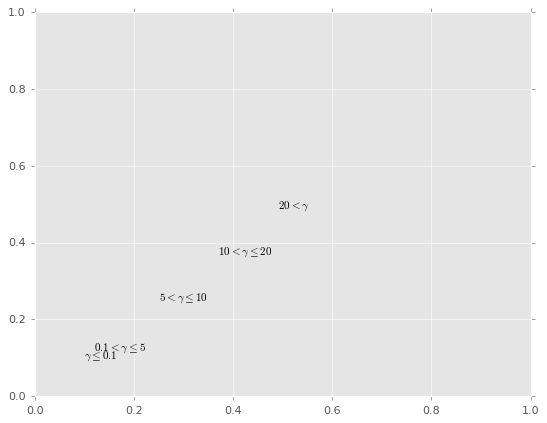

In [644]:
a = getClasses([0.1, 5, 10, 20])
# fig = plt.figure()
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
ax.text(0.1, 0.1, a[0])
ax.text(0.12, 0.12, a[1])
ax.text(0.25, 0.25, a[2])
ax.text(0.37, 0.37, a[3])
ax.text(0.49, 0.49, a[4])

In [645]:
def getClasses(endpoints):
    nclass = len(endpoints) + 1
    classes = []
    for idx, val in enumerate(endpoints):
        if idx == 0:
            classes.append("$\gamma\leq{}$".format(val))
        elif idx == len(endpoints) - 1:
            classes.append("${}<\gamma\leq{}$".format(endpoints[idx - 1], val)) 
            classes.append("${}<\gamma$".format(val))
        else:
            classes.append("${}<\gamma\leq{}$".format(endpoints[idx - 1], val))
            
    return classes

In [646]:
class perfeval:
    
    @staticmethod
    def tspredict(y_true, y_pred, outd=None, **kwarg):

        if not isinstance(y_true, np.ndarray):
            y_true = np.array(y_true)

        if not isinstance(y_pred, np.ndarray):
            y_pred = np.array(y_pred)
            
        assert y_true.shape[0] == y_pred.shape[0]

        ###  config
        props = dict(boxstyle="round", facecolor="red", alpha=0.5)
        
        if "y_class_true" in kwarg.keys() and "y_class_pred" in kwarg.keys():
            cm = confusion_matrix(kwarg["y_class_true"], kwarg["y_class_pred"])

        if "classes" in kwarg.keys():
            classes = kwarg["classes"]
        elif "classify" in kwarg.keys():
            endpoints = kwarg["classify"]
            nclass = len(endpoints) + 1
            classes = getClasses(endpoints)
        
        xposi_ = None
        if "xposi" in kwarg.keys():
            xposi_ = kwarg["xposi"]

        xlabel_ = None
        if "xlabel" in kwarg.keys():
            xlabel_ = kwarg["xlabel"]

        title_ = None
        if "title" in kwarg.keys():
            title_ = kwarg["title"]

        toffset = 0
        if "toffset" in kwarg.keys():
            toffset = kwarg["toffset"]
        
        if "task" in kwarg.keys() and kwarg["task"] == "classification":
            cm = metrics.confusion_matrix(y_true, y_pred)
            cmdf = pd.DataFrame(cm, columns=classes)

            clsreport = metrics.classification_report(y_true, y_pred, digits=4, output_dict=True)
            df = pd.DataFrame()
            for i in clsreport.keys():
                if i == "accuracy":
                    acc = clsreport[i]
                    continue
                df_ = pd.DataFrame(clsreport[i], index=[i])
                df = pd.concat([df, df_], axis=0)
    
            fig = plt.figure(figsize=(16, 10)) 
            ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
            ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
            ax3 = plt.subplot2grid((4, 4), (2, 1), rowspan=2, colspan=2)

            display_table(df, ax1, dtype=None, onlytable=True, treverse=True, tloc="center right", tscale=(0.75, 2.75), title="Accuracy, Precision, and Recall")
            plot_confusion_matrix(cm, fig=fig, ax=ax2, classes=classes, normalize=True)
            display_table(cmdf, ax3, dtype="cm", tscale=(1, 2), offset=toffset, bar_width=0.4, title="TP, TN, FP, FN")
            fig.tight_layout()
            
            if outd is not None:
                outf = "{}/perfeval.png".format(outd)
                if title_ is not None:
                    outf = "{}/perfeval_{}.png".format(outd, title_)

                logging.debug("tspredict".format(outf))
                plt.savefig(outf)
            else:
                plt.show()
            
            plt.close()
        else:
            if "classify" in kwarg.keys():
                endpoints = kwarg["classify"]
                y_max = np.nanmax(y_true) 
                if y_max < endpoints[-1]:
                    endpoints.append(endpoints[-1] + 10)
                else:
                    endpoints.append(y_max)

                y_pred_ = np.copy(y_pred)
                y_pred = [endpoints[i] for i in y_pred] 

            ###  preprocessing    
            minv = min(np.min(y_true), np.min(y_pred))
            maxv = max(np.max(y_true), np.max(y_pred))

            residual_ = y_pred - y_true
            nsize = len(residual_)
            rmse = (np.apply_along_axis(lambda x: x**2, 0, residual_).mean() / nsize)**0.5
            mu_  = residual_.mean()
            std_ = residual_.std(ddof=1)

            ###  normality test
            # the null hypothesis that the data was drawn from a normal distribution.
            stests, stestp = stats.shapiro(residual_)

            # the null hypothesis that a sample comes from a normal distribution.
            ntests, ntestp = stats.normaltest(residual_)

            descstat = "($\mu$, $\sigma$) = ({0:7.3f}, {1:7.3f})\n(shapiro, ntest) = ({2:7.3f}, {3:7.3f})".format(mu_, std_, stestp, ntestp)

            plt.figure(figsize=(16, 10))

            logging.debug("tspredict-fig1")
            ax1 = plt.subplot2grid(shape=(7, 4), loc=(0, 0), rowspan=3, colspan=4)

            ax1.plot(y_true, label="$y_{true}$") 
            if "classify" in kwarg.keys(): 
                ax1.step(np.arange(nsize), y_pred, label="$\hat{y}_{pred}$")
            else:
                ax1.plot(y_pred, label="$\hat{y}_{pred}$")

            if "steps" in kwarg.keys():
                ax1.plot(kwarg["steps"], label="classification")


            if (xposi_ is not None) and (xlabel_ is not None):
                assert len(xposi_) == len(xlabel_)
                ax1.set_xticks(xposi_)    
                ax1.set_xticklabels(xlabel_)    

            if title_ is not None:
                plt.title(title_)

            ax1.legend(fontsize=14)

            logging.debug("tspredict-fig2")
            ax2 = plt.subplot2grid(shape=(7, 4), loc=(3, 0), rowspan=2, colspan=4)
            ax2.plot(residual_, label="residual", color="blue")
            ax2.plot(np.zeros(nsize), "--", color="red")

            if (xposi_ is not None) and (xlabel_ is not None):
                ax2.set_xticks(xposi_)    
                ax2.set_xticklabels(xlabel_)   

            ax2.legend(fontsize=14)

            ax2.text(nsize, min(residual_), "RMSE = {0:>7.3f}".format(rmse),
                     verticalalignment="bottom", horizontalalignment="right",
                     color="black", fontsize=14, bbox=props)

            logging.debug("tspredict-fig3-error.dist")
            ax3 = plt.subplot2grid(shape=(7, 4), loc=(5, 0), rowspan=2, colspan=2)
            n, bins, patches = ax3.hist(residual_, bins=30, density=True, stacked=True, label="residual", facecolor="g", alpha=0.75)
            resx = np.arange(min(residual_), max(residual_), 0.001)
            resnpdf = norm(mu_, std_).pdf(resx)
            ax3.plot(resx, resnpdf, label="normal", color="red")
            ax3.text(bins[int(len(bins) * 0.001)], max(n) * 0.45, s=descstat, fontsize=12, bbox=props)
            ax3.legend(fontsize=14)

            logging.debug("tspredict-fig4")
            ax4 = plt.subplot2grid(shape=(7, 4), loc=(5, 2), rowspan=2, colspan=2)
            ax4.scatter(y_true, y_pred, label="residual", color="skyblue")
            ax4.plot([minv, maxv], [minv, maxv], "--", color="red")

            plt.tight_layout()

            if outd is not None:
                outf = "{}/perfeval.png".format(outd)
                if title_ is not None:
                    outf = "{}/perfeval_{}.png".format(outd, title_)

                logging.debug("tspredict".format(outf))
                plt.savefig(outf)
            else:
                plt.show()

            plt.close()

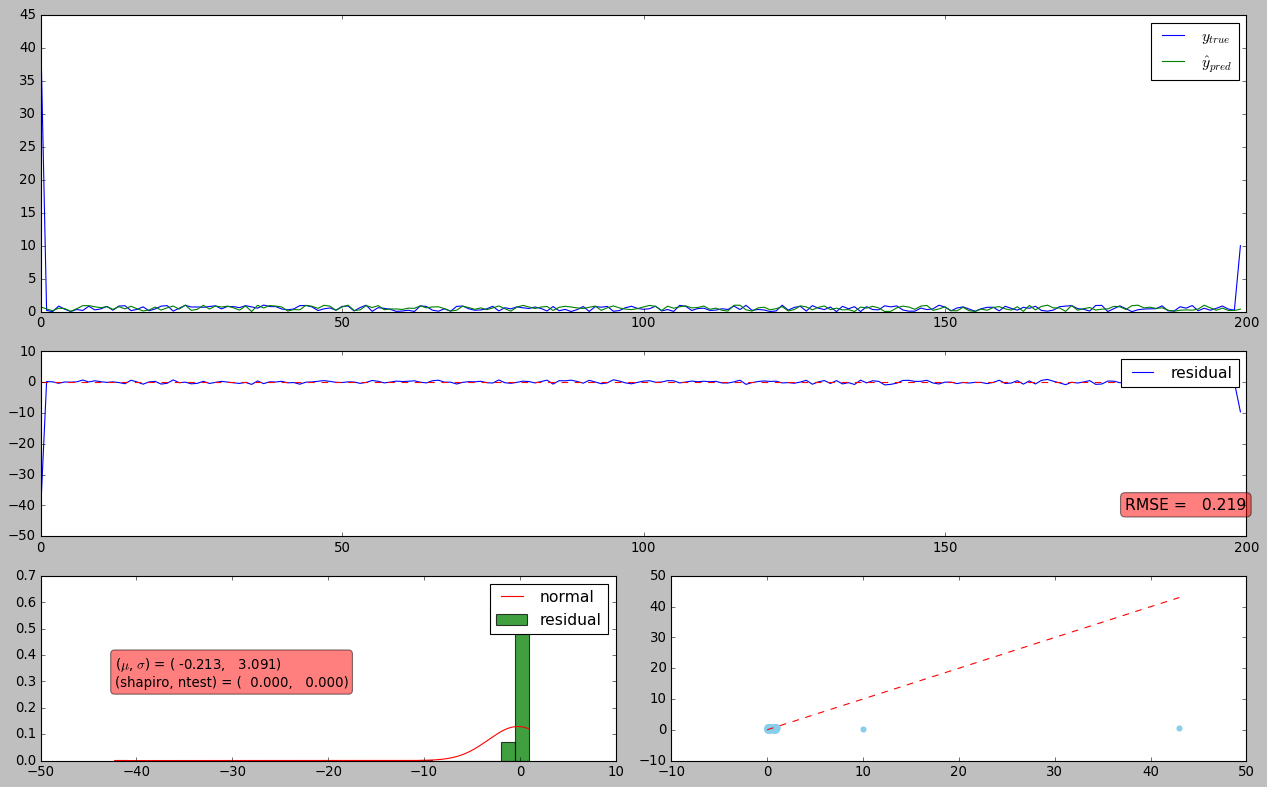

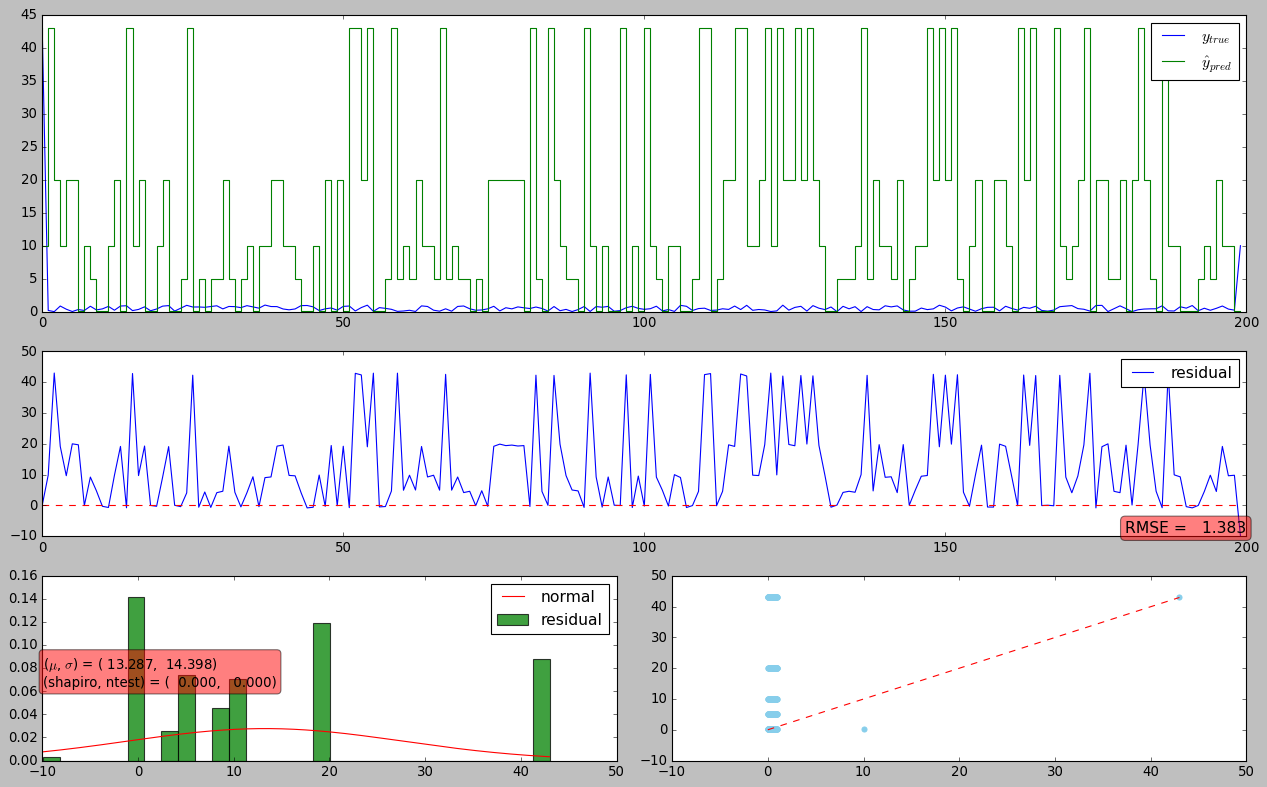

In [606]:

if __name__ == "__main__":

    n = 200
    y_true = np.random.random_sample(n)
    y_pred = np.random.random_sample(n)

    y_true[-1] = 10
    y_true[0] = 43
    perfeval.tspredict(y_true, y_pred)

    
    
    classify = [0.1, 5, 10, 20]
    if np.nanmax(y_true) < classify[-1]:
        classify.append(classify[-1] + 10)
    else:
        classify.append(np.nanmax(y_true))
        
    y_pred = np.random.choice([0, 1, 2, 3, 4], n, replace=True)
#     y_pred = [classify[i] for i in y_pred]
    
    perfeval.tspredict(y_true, y_pred, classify=classify)


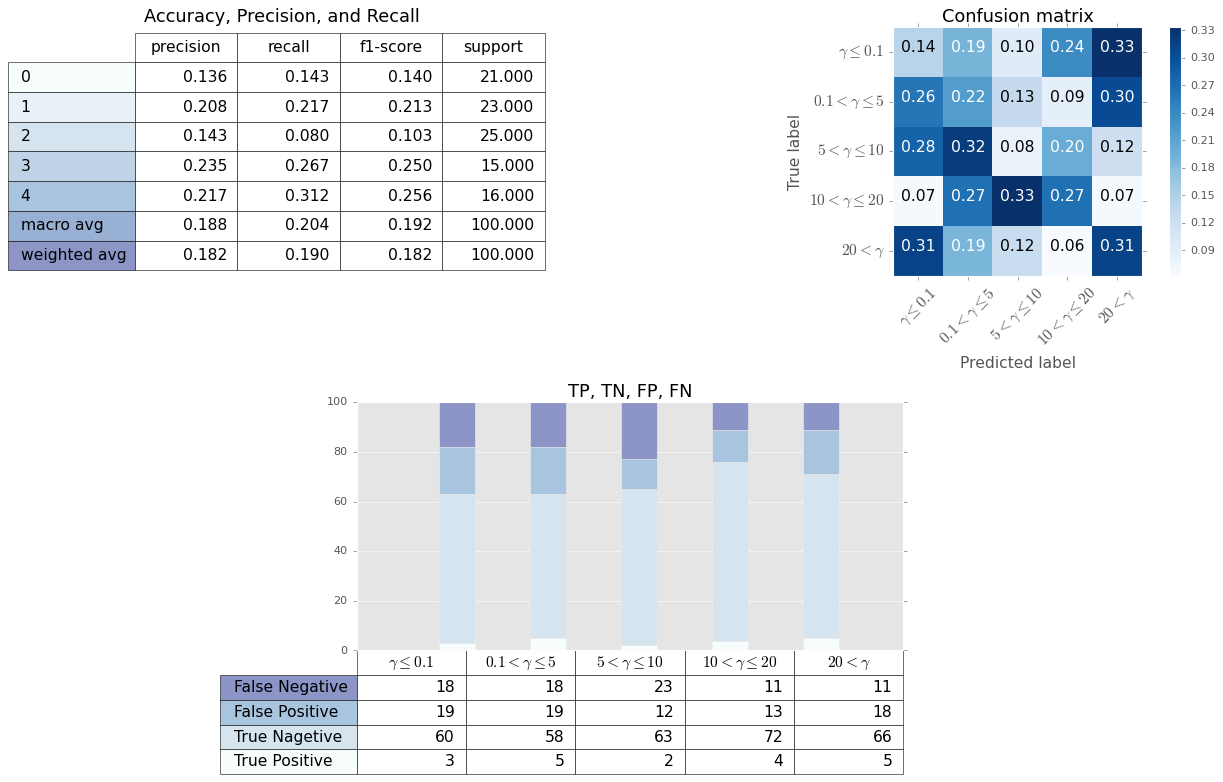

In [657]:
n = 100
y_true = np.random.choice([0, 1, 2, 3, 4], n, replace=True)
y_pred = np.random.choice([0, 1, 2, 3, 4], n, replace=True)
classes = getClasses([0.1, 5, 10, 20])
perfeval.tspredict(y_true, y_pred, task="classification", classes=classes, toffset=0.1)

cm = metrics.confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
clsreport = metrics.classification_report(y_true, y_pred, digits=4, output_dict=True)


In [176]:
print(metrics.classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.3438    0.2750    0.3056        40
           1     0.3333    0.3235    0.3284        34
           2     0.1143    0.1538    0.1311        26

    accuracy                         0.2600       100
   macro avg     0.2638    0.2508    0.2550       100
weighted avg     0.2805    0.2600    0.2680       100



In [353]:
(36*0.356164+33*0.317460+31*0.343750)/100.

0.33954334

In [597]:
df = pd.DataFrame()
for i in clsreport.keys():
    if i == "accuracy":
        acc = clsreport[i]
        print(acc)
        continue
    df_ = pd.DataFrame(clsreport[i], index=[i])
#     print(df_)
    df = pd.concat([df, df_], axis=0)
    
df

0.34


,precision,recall,f1-score,support
0,0.351351,0.361111,0.356164,36
1,0.333333,0.303030,0.317460,33
2,0.333333,0.354839,0.343750,31
macro avg,0.339339,0.339660,0.339125,100
weighted avg,0.339820,0.340000,0.339544,100


In [580]:
def display_table(df, ax, dtype=None, onlytable=False, treverse=False, tloc="bottom", tscale=(1, 2), offset=0.3, bar_width=0.4, title=None):

    columns = df.columns.tolist()
    nclass = len(columns)

    if dtype == "cm":
        TP  = np.zeros(nclass)
        TN  = np.zeros(nclass)
        FP  = np.zeros(nclass)
        FN  = np.zeros(nclass)
        arr = df.values
        for i in range(nclass):
            TP[i] = arr[i, i]
            TN[i] = np.delete(np.delete(arr, i, axis=0), i, axis=1).sum()
            FP[i] = np.delete(arr, i, axis=0)[:, i].sum()
            FN[i] = np.delete(arr, i, axis=1)[i, :].sum()

        rows = ["True Positive", "True Nagetive", "False Positive", "False Negative"]
        data = np.array([TP, TN, FP, FN])
    else:
        rows = df.index.tolist()
        data = df.values

    nrow   = len(rows)
    colors = plt.cm.BuPu(np.linspace(0, 0.5, nrow))
    index  = np.arange(nclass) + offset

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(nclass)

    # Plot bars and create text labels for the table
    celltext = []
    for row in range(nrow):
        if not onlytable:
            ax.bar(index, data[row, :], bar_width, bottom=y_offset, color=colors[row])
        y_offset = y_offset + data[row]
    #     celltext.append(["%1.1f" % x for x in y_offset])
        if dtype == "cm":
            celltext.append(["%d" % data[row, j] for j in range(nclass)])
        else:
            celltext.append(["%.3f" % data[row, j] for j in range(nclass)])


    # Reverse colors and text labels to display the last value at the top.
    if not treverse:
        colors = colors[::-1]
        rows.reverse()
        celltext.reverse()

    if onlytable:
        ax.axis("off")

    # Add a table at the bottom of the axes
    table = ax.table(cellText=celltext, 
                     rowLabels=rows,
                     rowColours=colors,
                     colLabels=columns, 
                     loc=tloc)

    table.set_fontsize(14)
    table.scale(tscale[0], tscale[1])

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.1, bottom=0.2)

#     plt.ylabel("")
    # plt.yticks(values * value_increment, ['%d' % val for val in values])
    ax.set_xticks([])
    if title is not None:
        ax.set_title(title, fontsize=16)

#     plt.show()

0.3366666666666666

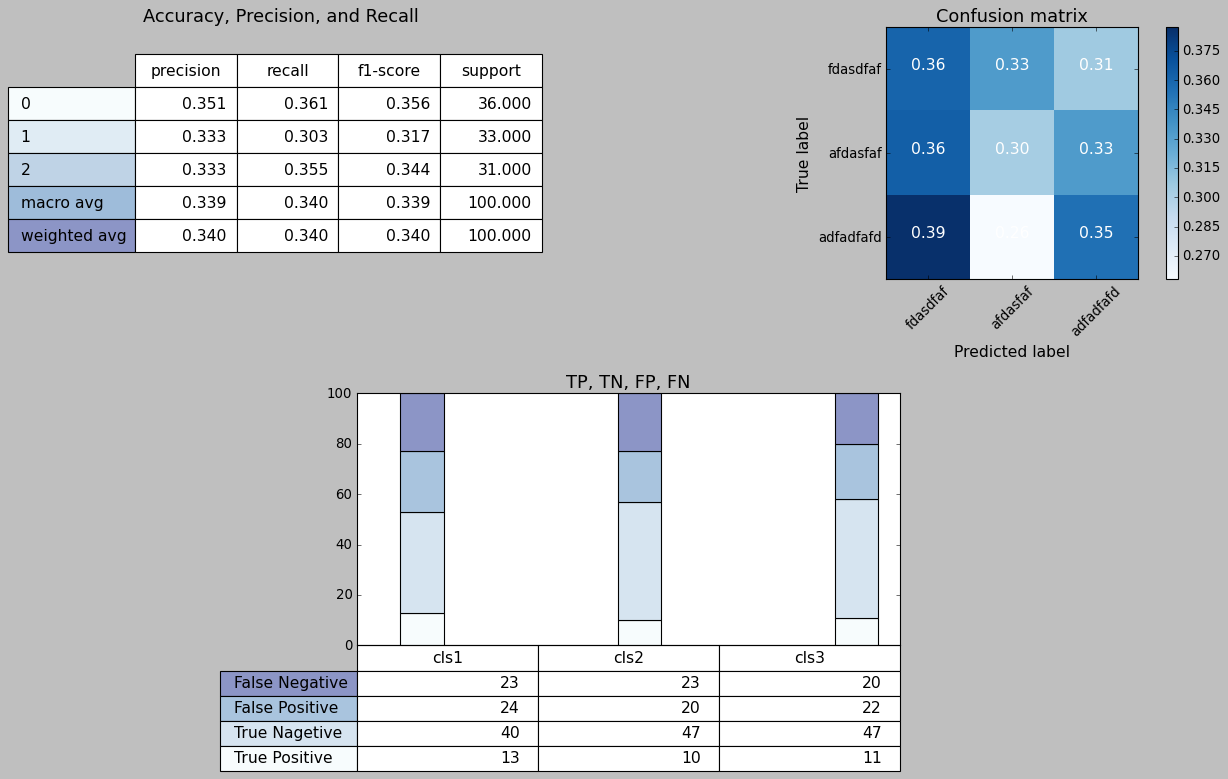

In [598]:
fig = plt.figure(figsize=(16, 10)) 
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)


# ax1 = ax_[0, 0]
ax2 = ax_[0, 1]
ax3 = ax_[1, 0]

ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 4), (2, 1), rowspan=2, colspan=2)

onlytable=False
onlytable=True

dtype = "df"
offset=0.3
bar_width =0.4
treverse=True
title="Accuracy, Precision, and Recall"
tscale=(0.5, 1)
tloc="bottom"
tloc="center right"


display_table(df, ax1, dtype=None, onlytable=onlytable, treverse=treverse, tloc=tloc, tscale=(0.75, 3), offset=0.3, bar_width=0.4, title=title)
plot_confusion_matrix(cm, fig=fig, ax=ax2, classes=["fdasdfaf", "afdasfaf", "adfadfafd"], normalize=True)

cmdf = pd.DataFrame(cm, columns=["cls1", "cls2", "cls3"])
display_table(cmdf, ax3, dtype="cm", onlytable=False, treverse=False, tloc="bottom", tscale=(1, 2), offset=0.3, bar_width=0.2, title="TP, TN, FP, FN")
fig.tight_layout()


In [261]:
import itertools

def plot_confusion_matrix(cm, 
                          classes,
                          ax=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        cm: confusion matrix whose indexes are true labels and columns are predicted labels
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # np.newaxis: increse one dimension
        logging.info("Normalized confusion matrix")
    else:
        logging.info('Confusion matrix, without normalization')


    if ax is None:
        ax = plt
    
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    try:
        ax.title(title)
    except:
        ax.set_title(title)
        
    ax.colorbar()
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes, rotation=45)
    ax.set_yticks(tick_marks, classes)
    ax.grid(b=False)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.ylabel('True label')
    ax.xlabel('Predicted label')
    ax.tight_layout()
 

In [307]:
y_class = np.random.choice([0, 1, 4], 100)

y_class_ = np.copy(y_class)
# print(y_class)
y_class = pd.DataFrame({'y_class': y_class})
# y_class = pd.get_dummies(y_class['y_class']).values
y_class = pd.get_dummies(y_class['y_class'])
# print(type(y_class))
# print(y_class)
# y_class.T.reindex([0, 1, 2, 3, 4, 5]).fillna(0).T.values
# y_class.T.reindex([0, 1, 2, 3, 4, 5]).T.fillna(0)

# y_class = np.argmax(y_class, axis=1)

# ROC Curve

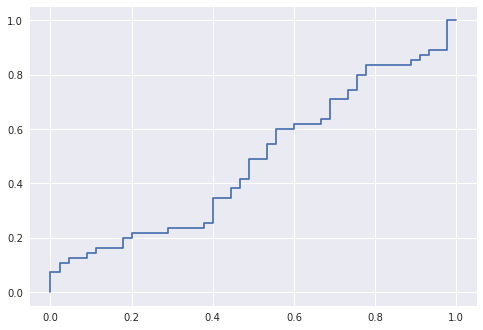

In [336]:
y = np.random.choice([0, 1], 100)
scores = np.random.rand(100)
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
fpr
tpr
thresholds
plt.plot(fpr, tpr)

# 3D classification

In [324]:
from mpl_toolkits.mplot3d import Axes3D

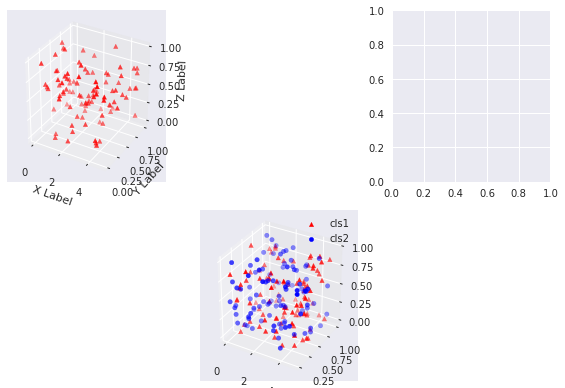

In [335]:
def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(231, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
# for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)
#     ax.scatter(xs, ys, zs, c=c, marker=m)

Temp = np.random.rand(100) * 5
RH = np.random.rand(100)
Precp = np.random.rand(100)

ax.scatter(xs=Temp, ys=RH, zs=Precp, c="r", marker="^")


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax3 = fig.add_subplot(233)
ax5 = fig.add_subplot(235, projection="3d")
Temp = np.random.rand(100) * 5
RH = np.random.rand(100)
Precp = np.random.rand(100)

ax5.scatter(xs=Temp, ys=RH, zs=Precp, c="r", marker="^", label="cls1")
Temp = np.random.rand(100) * 5
RH = np.random.rand(100)
Precp = np.random.rand(100)

ax5.scatter(xs=Temp, ys=RH, zs=Precp, c="b", marker="o", label="cls2")
ax5.legend()

plt.tight_layout()
plt.show()
